<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/acca_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common

In [2]:
!pip install boto3 awscli
!pip install pandas

import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.1.3 requires docutils<0.22,>=0.20, but you have docutils 0.16 which is incompatible.


In [7]:
from google.colab import userdata

os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
os.environ['AWS_DEFAULT_REGION'] = 'us-west-2'

In [17]:
ALL_ERRORS = [
    "ENTER_CIRCUIT_NAME",  # TODO: remove
    "CIRCUIT_ALREADY_EXISTS",
    "CIRCUIT_CONTAINS_ILLEGAL_CHAR",
    "CANNOT_CONNECT_ACROSS_ELEMENT",
    "CANNOT_SIMULATE_CIRCUIT",
    "NO_GROUND_NODE",
    "FLOATING_NODE",
    "NO_INTERNET_CONNECTION",  # TODO: implement
    "CONNECT_GROUND",
    "INVALID_EMAIL",
    "PASSWORD_TOO_SHORT",
    "PASSWORD_INVALID_CHARS",
    "PASSWORD_MUST_MATCH",
    "EMAIL_ALREADY_IN_USE",  # TODO: implement
    "CANNOT_CONNECT_TO_SERVER",
    "SERVER_ERROR",
    "SIGNUP_ERROR",
    "LOGIN_ERROR",
    "EMAIL_IN_USE_PASSWORD_INCORRECT",
    "INVALID_LOGIN",
    "PURCHASE_ERROR",
    "MOVE_ELEMENT",
    "COMMA_INSTEAD_OF_PERIOD_IN_NUMBER",
    "CLICK_OUTSIDE_KEYBOARD",
    "OVERLAPPING_WITH_DIAGONAL_LINE",  # TODO: implement
    "UNKNOWN_CHAR_ERROR",
    "LOAD_CIRCUIT_ERROR",
    "OPERATION_ON_INVALID_ELEMENT",
    "ZERO_VALUE_ELEMENT",
    "CANNOT_LOAD_ERROR_DEFINITIONS",
    "TUTORIAL_MAPPING_MISSING",
    "GENERAL_TUTORIAL_ERROR",
    "RESTORE_ERROR",
    "WAIT_ERROR"
]

SYSTEM_ERRORS = [
    "CIRCUIT_CONTAINS_ILLEGAL_CHAR",
    "CANNOT_SIMULATE_CIRCUIT",
    "NO_INTERNET_CONNECTION",  # TODO: implement
    "CANNOT_CONNECT_TO_SERVER",
    "SERVER_ERROR",
    "PURCHASE_ERROR",
    "COMMA_INSTEAD_OF_PERIOD_IN_NUMBER",
    "CLICK_OUTSIDE_KEYBOARD",
    "OVERLAPPING_WITH_DIAGONAL_LINE",  # TODO: implement
    "UNKNOWN_CHAR_ERROR",
    "LOAD_CIRCUIT_ERROR",
    "ZERO_VALUE_ELEMENT",
    "CANNOT_LOAD_ERROR_DEFINITIONS",
    "TUTORIAL_MAPPING_MISSING",
    "GENERAL_TUTORIAL_ERROR",
    "RESTORE_ERROR",
    "WAIT_ERROR"
]


In [12]:
from boto3.dynamodb.conditions import Attr, Key

# Initialize a session using Amazon DynamoDB
dynamodb = boto3.resource('dynamodb')

events_table = dynamodb.Table('events-table-prod')
errors_table = dynamodb.Table('errors-table-prod')

def build_df(items):
  if len(items) == 0:
    return None

  # Convert items to a pandas DataFrame
  df = pd.DataFrame(items)

  # Ensure the timestamp is numeric
  df['timestamp'] = pd.to_numeric(df['timestamp'])

  # Convert timestamp from milliseconds to seconds and then to datetime
  df['date'] = pd.to_datetime(df['timestamp'] // 1000, unit='s')

  return df


def get_events(filter_expression):
  # Initialize an empty list to hold all the items
  all_items = []

  # Perform the scan operation with pagination
  response = events_table.scan(
      FilterExpression=filter_expression
  )

  # Add the initial items to the list
  all_items.extend(response['Items'])

  # Continue scanning if there are more pages of data
  while 'LastEvaluatedKey' in response:
      response = events_table.scan(
          FilterExpression=filter_expression,
          ExclusiveStartKey=response['LastEvaluatedKey']
      )
      all_items.extend(response['Items'])


  return build_df(all_items)

def get_errors_type(error_type, min_timestamp):
  # Define the query expression
  key_condition_expression = Key('errorType').eq(error_type) & Key('timestamp').gt(min_timestamp)


  # Perform the query operation
  response = errors_table.query(
      KeyConditionExpression=key_condition_expression
  )

  all_items = response.get('Items', [])
  print(f"Initial query retrieved {len(all_items)} items")

  # Continue querying if there are more pages of data
  while 'LastEvaluatedKey' in response:
      print('Extending...')
      response = errors_table.query(
        KeyConditionExpression=key_condition_expression,
        ExclusiveStartKey=response['LastEvaluatedKey']
      )
      new_items = response.get('Items', [])
      all_items.extend(new_items)
      print(f"Retrieved {len(new_items)} more items, total now {len(all_items)}")

  return build_df(all_items)

def get_errors(filter_expression):
  # Initialize an empty list to hold all the items
  all_items = []

  # Perform the scan operation with pagination
  response = errors_table.scan(
      FilterExpression=filter_expression
  )

  # Add the initial items to the list
  all_items.extend(response['Items'])

  # Continue scanning if there are more pages of data
  while 'LastEvaluatedKey' in response:
      response = errors_table.scan(
          FilterExpression=filter_expression,
          ExclusiveStartKey=response['LastEvaluatedKey']
      )
      all_items.extend(response['Items'])

  if len(all_items) == 0:
    return None

  return build_df(all_items)

def get_daily_counts(df):
  # Extract the date part only (without time)
  df['date_only'] = df['date'].dt.date

  # Group by the date and count the number of items per day
  counts_per_day = df['date_only'].value_counts().sort_index()

  return counts_per_day

# Recent Errors

# Tracing Users

This section will investigate into several users

## Angry at start of trial

### Story

This section will demonstrate a user who downloaded the ACCA on 5/22/2023. He tried to create a circuit, but could not quite get rid of the "Connect Ground" error.

However, our intrepid user continued to venge forth. Coming back the very next day 5/23/2023, but was still unable to create a correct circuit. This repeated on 5/27/2023

At this point, our hero user 1748dc6266b0ba30, almost gave up then 4 days later on 5/31/2023 he returned. Smarter and wiser than ever, and by god he did it. He successfully executed his first circuit at 6:44 UTC.

However to our customer's horror... he is met with a paywall! Our valiant hero has spent over a week at this point getting this damn app to work just to get a paywall? What happened?

### Analysis

When our hero openned the app on 5/22/2023, he started his free trial. So even though it took him until 5/31/2023 to get the app to work his trial expired midnight on 5/29/2023. So all of his effort after that point was lost since he had no clue that any attempts would fail, and his only solution was to blindly hand his card to this app he has never gotten to work.

### Solution

The free trial should only begin after the user successfully runs his/her first circuit. Before this time they are mostly just struggling and that should not be considered "testing out the app."

#### Update

Considering there is now a free trial. We most likely dont have to worry about this.


In [ ]:
USER_ID = '1748dc6266b0ba30'

In [ ]:
# Define a filter expression
filter_expression = Attr('userId').eq(USER_ID)

df = get_events(filter_expression)

# Print the DataFrame
df_events = df[['date', 'eventCode']]
df_events = df_events.rename(columns={
    'date': 'date',
    'eventCode': 'combinedEvent'
})

print(df_events)

                  date             combinedEvent
0  2023-05-31 06:44:02        CONNECTION_CREATED
1  2023-05-31 06:44:03        CONNECTION_CREATED
2  2023-05-31 06:44:05        CONNECTION_CREATED
3  2023-05-31 06:43:56                 GOTO_HOME
4  2023-05-31 06:43:57                 GOTO_HOME
5  2023-05-31 06:43:57                 GOTO_HOME
6  2023-05-31 06:43:57                 GOTO_HOME
7  2023-05-31 06:43:57                 GOTO_HOME
8  2023-05-31 06:43:57                 GOTO_HOME
9  2023-05-31 06:44:06     REJECTING_CIRCUIT_RUN
10 2023-05-31 06:43:59              ADD_INDUCTOR
11 2023-05-31 06:44:06  PROMPTING_USER_TO_UNLOCK
12 2023-05-31 06:44:11           PURCHASE_FAILED
13 2023-05-31 06:44:06               RUN_CIRCUIT
14 2023-05-31 06:44:06               RUN_CIRCUIT
15 2023-05-31 06:44:10       START_PURCHASE_FLOW


In [ ]:
from boto3.dynamodb.conditions import Attr

filter_expression = Attr('userId').eq(USER_ID)

df = get_errors(filter_expression)

df_errors = df[['date', 'errorType']]
df_errors = df_errors.rename(columns={
    'date': 'date',
    'errorType': 'combinedEvent'
})
df_errors['combinedEvent'] = df_errors['combinedEvent'].apply(lambda x: 'ERROR_' + x)

# Print the DataFrame
print(df_errors)

                   date                  combinedEvent
0   2023-05-23 07:29:58             ERROR_MOVE_ELEMENT
1   2023-05-23 07:29:59             ERROR_MOVE_ELEMENT
2   2023-05-23 07:29:59             ERROR_MOVE_ELEMENT
3   2023-05-27 03:49:56       ERROR_ZERO_VALUE_ELEMENT
4   2023-05-27 03:49:56       ERROR_ZERO_VALUE_ELEMENT
..                  ...                            ...
170 2023-05-27 03:50:27  ERROR_CANNOT_SIMULATE_CIRCUIT
171 2023-05-27 03:50:27  ERROR_CANNOT_SIMULATE_CIRCUIT
172 2023-05-27 03:50:27  ERROR_CANNOT_SIMULATE_CIRCUIT
173 2023-05-27 03:50:44  ERROR_CANNOT_SIMULATE_CIRCUIT
174 2023-05-27 03:50:44  ERROR_CANNOT_SIMULATE_CIRCUIT

[175 rows x 2 columns]


In [ ]:
df_combined = pd.concat([df_events, df_errors], ignore_index=True)
df_combined = df_combined.sort_values(by='date')
df_combined = df_combined.reset_index(drop=True)
df_combined

,date,combinedEvent
0,2023-05-22 05:09:10,ERROR_CONNECT_GROUND
1,2023-05-22 05:09:11,ERROR_CONNECT_GROUND
2,2023-05-22 05:09:11,ERROR_CONNECT_GROUND
3,2023-05-22 05:09:11,ERROR_CONNECT_GROUND
4,2023-05-23 07:09:52,ERROR_CONNECT_GROUND
...,...,...
186,2023-05-31 06:44:06,REJECTING_CIRCUIT_RUN
187,2023-05-31 06:44:06,PROMPTING_USER_TO_UNLOCK
188,2023-05-31 06:44:10,START_PURCHASE_FLOW
189,2023-05-31 06:44:11,PURCHASE_FAILED


# Error code breakdown

In [13]:
import time

counts_dfs = {}

# last year
min_timestamp = int(time.time()) - 90 * 24 * 60 * 60
counts = []
for error_type in ALL_ERRORS:
  print(f'checking error_type={error_type}')
  error_type_df = get_errors_type(error_type, min_timestamp)
  if error_type_df is None:
    continue

  print(f'found {len(error_type_df)} errors matching error_type=`{error_type}`')
  counts_dfs[error_type] = get_daily_counts(error_type_df)
  counts.append((error_type, len(error_type_df)))

sorted_counts = sorted(counts, key=lambda x: x[1], reverse=True)

checking error_type=ENTER_CIRCUIT_NAME
Initial query retrieved 0 items
checking error_type=CIRCUIT_ALREADY_EXISTS
Initial query retrieved 8 items
found 8 errors matching error_type=`CIRCUIT_ALREADY_EXISTS`
checking error_type=CIRCUIT_CONTAINS_ILLEGAL_CHAR
Initial query retrieved 9 items
found 9 errors matching error_type=`CIRCUIT_CONTAINS_ILLEGAL_CHAR`
checking error_type=CANNOT_CONNECT_ACROSS_ELEMENT
Initial query retrieved 272 items
found 272 errors matching error_type=`CANNOT_CONNECT_ACROSS_ELEMENT`
checking error_type=CANNOT_SIMULATE_CIRCUIT
Initial query retrieved 445 items
found 445 errors matching error_type=`CANNOT_SIMULATE_CIRCUIT`
checking error_type=NO_GROUND_NODE
Initial query retrieved 45 items
found 45 errors matching error_type=`NO_GROUND_NODE`
checking error_type=FLOATING_NODE
Initial query retrieved 942 items
found 942 errors matching error_type=`FLOATING_NODE`
checking error_type=NO_INTERNET_CONNECTION
Initial query retrieved 0 items
checking error_type=CONNECT_GROUND

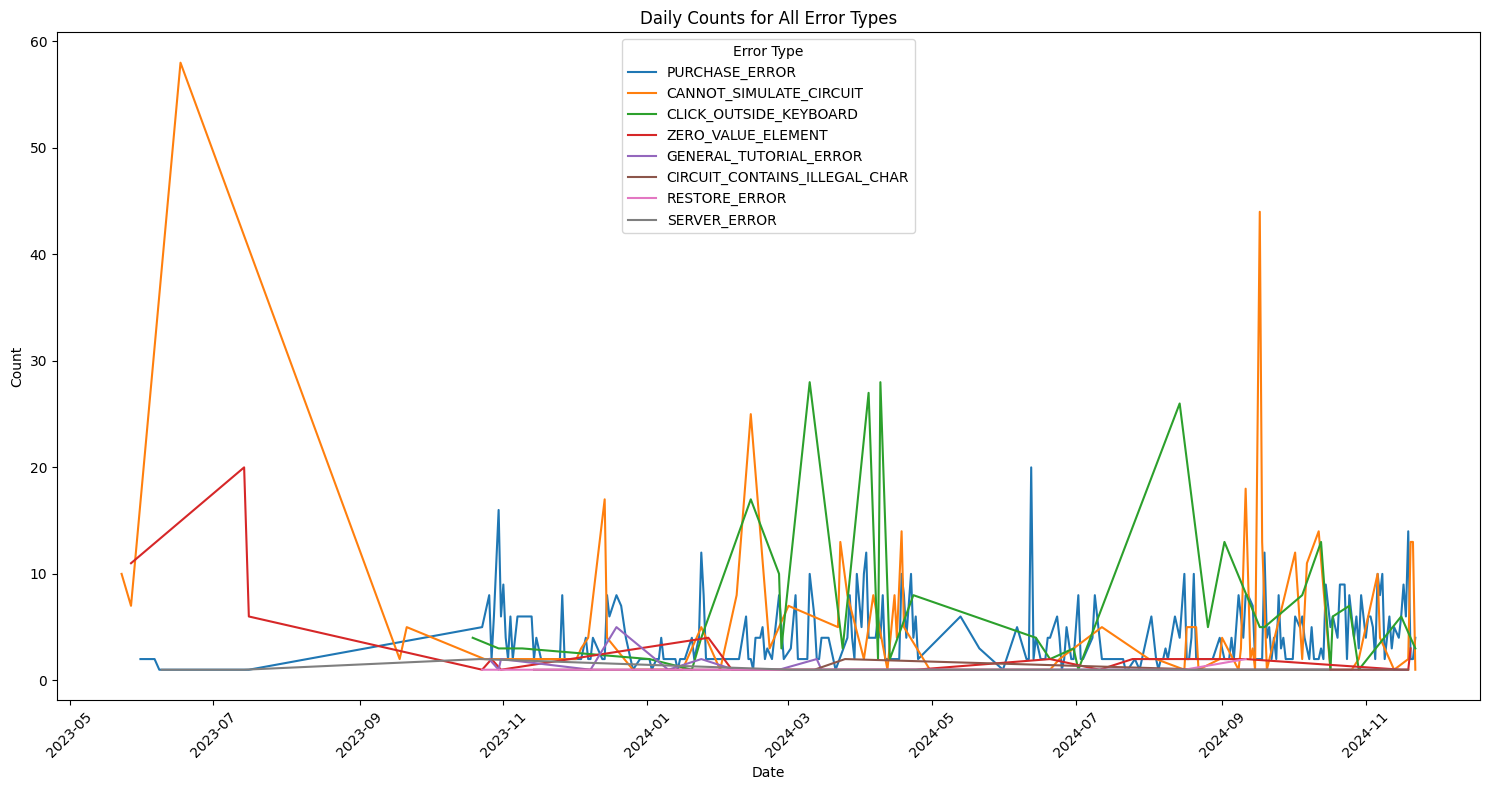

In [19]:
plt.figure(figsize=(15, 8))

# Plot all lines on the same graph
for error_type, _ in sorted_counts:
    if error_type not in SYSTEM_ERRORS:
        continue
    if error_type in counts_dfs:
        daily_counts = counts_dfs[error_type]
        daily_counts.plot(label=error_type)

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Add legend and labels
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Daily Counts for All Error Types')
plt.legend(title='Error Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()